# Plot mean, variance and correlation for yearly timescale and all Dabestets

In [1]:
from plotting import *
from evaluate import *

from mpl_toolkits.axes_grid1 import make_axes_locatable
from interpolate import get_interpolated_data_and_gt
import matplotlib

In [2]:
base_folder = "Datasets"
output_folder = "Output/Crossprediction"

### Load data

In [3]:
conditions = dict()
conditions["iHadCM3"] = {
        "DATASET_DESCRIPTION": {"TIMESCALE": "YEARLY", 
                                "DO_SHUFFLE": False,
                                "DATASETS_NO_GAPS": ['isotopes', 'tsurf', 'prec'],
                                "TARGET_VARIABLES": {'isotopes': ['d18O']},
                                "CLIMATE_MODEL": "iHadCM3",                                
                                },
        "MODEL_TRAINING_DESCRIPTION": {"MODEL_TYPE": "UNet_Flat"}
    }
conditions["GISS"] = {
        "DATASET_DESCRIPTION": {"TIMESCALE": "YEARLY", 
                                "DO_SHUFFLE": False,
                                "DATASETS_NO_GAPS": ['isotopes', 'tsurf', 'prec'],
                                "CLIMATE_MODEL": "GISS",
                                },
        "MODEL_TRAINING_DESCRIPTION": {"MODEL_TYPE": "UNet_Flat"}
    }
conditions["isoGSM"] = {
        "DATASET_DESCRIPTION": {"TIMESCALE": "YEARLY", 
                                "DO_SHUFFLE": False,
                                "DATASETS_NO_GAPS": ['isotopes', 'tsurf', 'prec'],
                                "CLIMATE_MODEL": "isoGSM",
                                },
        "MODEL_TRAINING_DESCRIPTION": {"MODEL_TYPE": "UNet_Flat"}
    }
conditions["iCESM"] = {
        "DATASET_DESCRIPTION": {"TIMESCALE": "YEARLY", 
                                "DO_SHUFFLE": False,
                                "DATASETS_NO_GAPS": ['isotopes', 'tsurf', 'prec'],
                                "CLIMATE_MODEL": "iCESM",
                                },
        "MODEL_TRAINING_DESCRIPTION": {"MODEL_TYPE": "UNet_Flat"}
    }


In [4]:
gt_l = []
descriptions_l = []
masks_l = []

for label, c in conditions.items():
    descriptions, _, gt, masks = load_data_for_comparison(output_folder, c)
    gt_l.append(gt)
    descriptions_l.append(descriptions)
    masks_l.append(masks)

10 matching runs found
10 matching runs found
10 matching runs found
10 matching runs found


### Mean states

C:\Users\49159\AppData\Local\Temp/ipykernel_29224/1258404398.py:6: RuntimeWarning: Mean of empty slice
  plot_map(ax[i//2,i%2], np.nanmean(gt_l[i][0],axis=(0,1)), descriptions_l[i][0]["DATASET_DESCRIPTION"], mean_style,


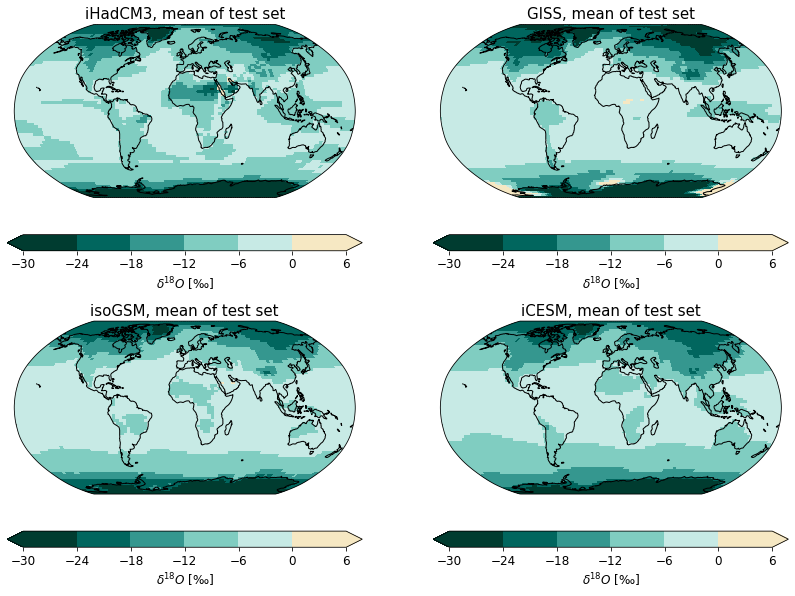

In [5]:
n_rows=2
n_cols=2

fig, ax = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=np.array([n_cols, n_rows])*mean_style["FIGSIZE"], subplot_kw={'projection': mean_style["PROJECTION"]})
for i, key in enumerate(list(conditions.keys())):
    plot_map(ax[i//2,i%2], np.nanmean(gt_l[i][0],axis=(0,1)), descriptions_l[i][0]["DATASET_DESCRIPTION"], mean_style, 
             title=descriptions_l[i][0]["DATASET_DESCRIPTION"]["CLIMATE_MODEL"]+", mean of test set")

plt.savefig("Images/means.jpg")
plt.savefig("Images/means.png")
plt.savefig("Images/means.pdf")
plt.show()

### Standard deviations

c:\Users\49159\Anaconda3\envs\GrouPyTorch\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


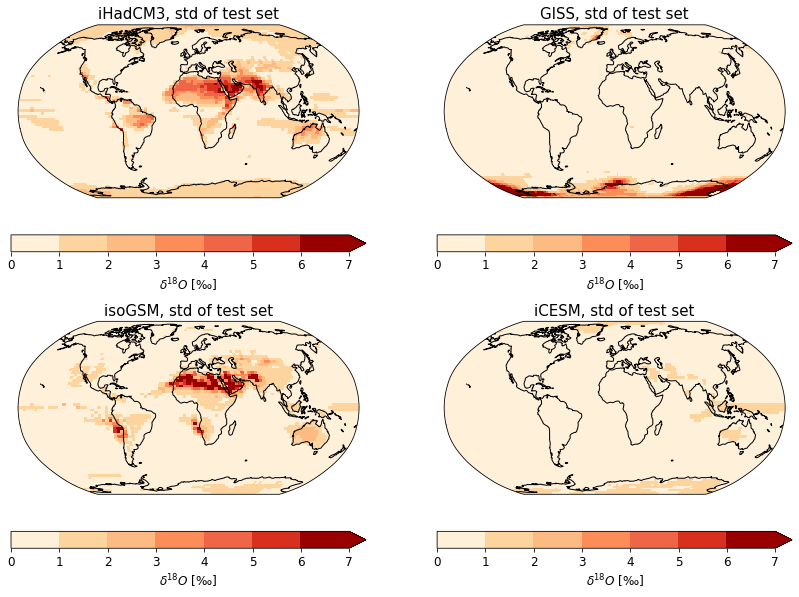

In [6]:
n_rows=2
n_cols=2

fig, ax = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=np.array([n_cols, n_rows])*std_style["FIGSIZE"], subplot_kw={'projection': std_style["PROJECTION"]})
for i, key in enumerate(list(conditions.keys())):
    plot_map(ax[i//2,i%2], np.nanstd(gt_l[i][0],axis=(0,1)), descriptions_l[i][0]["DATASET_DESCRIPTION"], std_style, 
             title=descriptions_l[i][0]["DATASET_DESCRIPTION"]["CLIMATE_MODEL"]+", std of test set")

plt.savefig("Images/stds.jpg")
plt.savefig("Images/stds.png")
plt.savefig("Images/stds.pdf")
plt.show()

### Correlation maps

In [7]:
dsets = []
for d in descriptions_l:
    dsets.append(find_and_load_dataset(output_folder, d[0]["DATASET_DESCRIPTION"]))

In [8]:
data_dicts = []
for ds in dsets:
    t = ds["train"]["predictors"][:,:1,...]  # second index is for specifying the variables
    p = ds["train"]["predictors"][:,1:,...]  # second index is for specifying the variables
    o = ds["train"]["targets"][:]
    
    c_t = get_correlation(t,o)[0,...]
    c_p = get_correlation(p,o)[0,...]

    max_cor = np.amax([abs(c_p),abs(c_t)], axis=0)
    argmax_cor = np.argmax([abs(c_p),abs(c_t)],axis=0)
    
    tas_mask = np.where((argmax_cor == 1),True,False)
    pr_mask = np.where((argmax_cor == 0),True,False)

    tas_img = np.ma.masked_array(max_cor, np.invert(tas_mask))
    pr_img = np.ma.masked_array(max_cor, np.invert(pr_mask))

    data_dict = {"tsurf": tas_img,
                 "prec": pr_img}
    data_dicts.append(data_dict)

c:\Users\49159\Anaconda3\envs\GrouPyTorch\lib\site-packages\scipy\stats\stats.py:3913: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


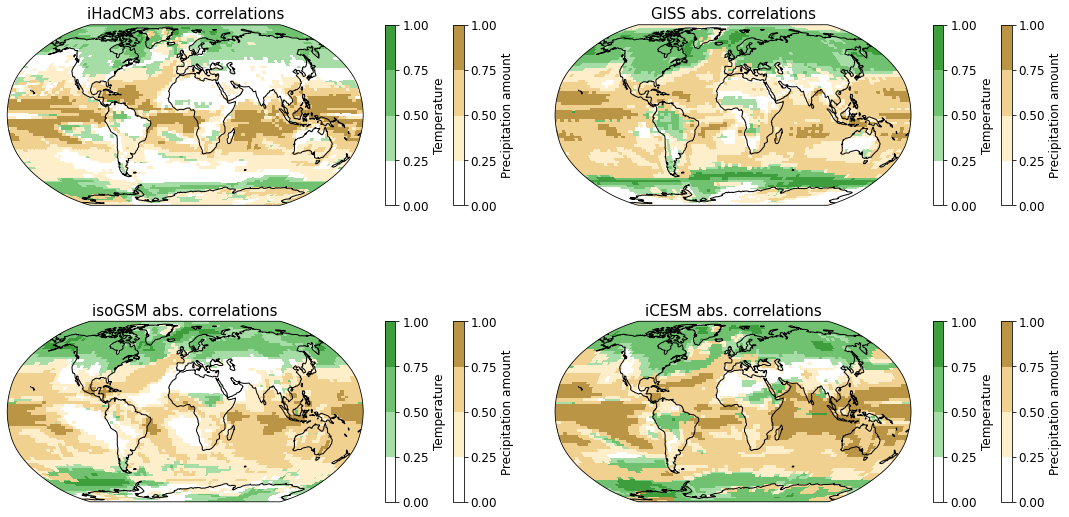

In [9]:
n_rows=2
n_cols=2

fig, ax = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=np.array([n_cols, n_rows])*corr_style["FIGSIZE"], subplot_kw={'projection': mean_style["PROJECTION"]})
for i, m_key in enumerate(list(conditions.keys())):
    plot_masked_data(ax[i//2,i%2], data_dicts[i], descriptions_l[i][0]["DATASET_DESCRIPTION"], corr_style, 
                     title=m_key +" abs. correlations")
    
    divider = make_axes_locatable(ax[i//2,i%2])
    for j, key in enumerate(list(data_dicts[i].keys())):
        if j==0:
            ax_cb = divider.new_horizontal(size="3%", pad=0.3, axes_class=plt.Axes)
        else:
            ax_cb = divider.new_horizontal(size="3%", pad=0.8, axes_class=plt.Axes)            
        fig.add_axes(ax_cb)
        cbar = fig.colorbar(
            matplotlib.cm.ScalarMappable(cmap=corr_style["CMAPS"][key], norm=corr_style["NORM"]),
            spacing='proportional',
            orientation='vertical',
            extend=corr_style["CBAR_EXTEND"], cax=ax_cb)
        cbar.set_label(corr_style["CBAR_LABELS"][key], fontsize=corr_style["CBAR_FONTSIZE"])
        cbar.ax.tick_params(labelsize=corr_style["CBAR_FONTSIZE"])

plt.savefig("Images/corrs.jpg")
plt.savefig("Images/corrs.png")
plt.savefig("Images/corrs.pdf")
plt.show()

### HadCM3 plots in one.

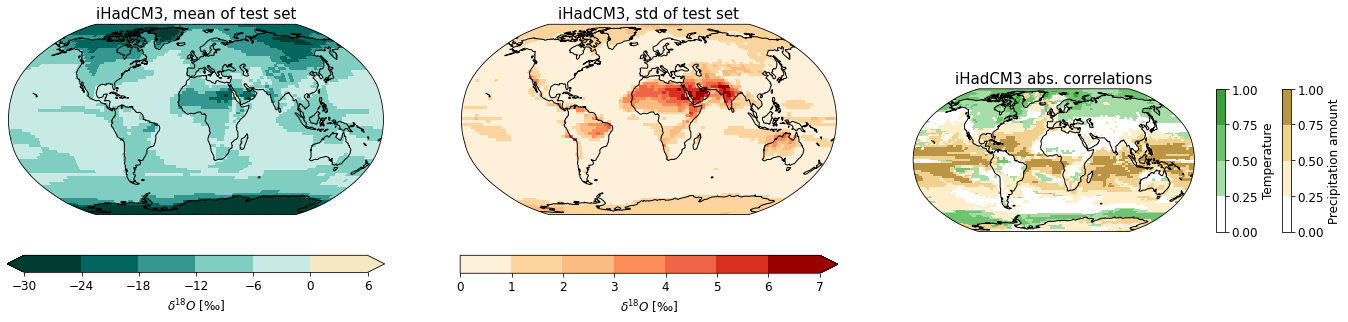

In [10]:
n_rows=1
n_cols=3

i=0  # index of desired climate model

fig, ax = plt.subplots(nrows=n_rows, ncols=n_cols,\
    figsize=np.array([mean_style["FIGSIZE"][0]+std_style["FIGSIZE"][0]+corr_style["FIGSIZE"][0], corr_style["FIGSIZE"][1]]), \
    subplot_kw={'projection': corr_style["PROJECTION"]}, gridspec_kw={'width_ratios': np.array([mean_style["FIGSIZE"][1],
    std_style["FIGSIZE"][1], corr_style["FIGSIZE"][1]])})

# mean:
plot_map(ax[0], np.nanmean(gt_l[i][0],axis=(0,1)), descriptions_l[i][0]["DATASET_DESCRIPTION"], mean_style, 
            title=descriptions_l[i][0]["DATASET_DESCRIPTION"]["CLIMATE_MODEL"]+", mean of test set", 
            cbar_orientation="horizontal")
# std:
plot_map(ax[1], np.nanstd(gt_l[i][0],axis=(0,1)), descriptions_l[i][0]["DATASET_DESCRIPTION"], std_style, 
            title=descriptions_l[i][0]["DATASET_DESCRIPTION"]["CLIMATE_MODEL"]+", std of test set", 
            cbar_orientation="horizontal")
            
# correlations:
plot_masked_data(ax[2], data_dicts[i], descriptions_l[i][0]["DATASET_DESCRIPTION"], corr_style, 
                    title=descriptions_l[i][0]["DATASET_DESCRIPTION"]["CLIMATE_MODEL"] +" abs. correlations")

divider = make_axes_locatable(ax[2])
for j, key in enumerate(list(data_dicts[i].keys())):
    if j==0:
        ax_cb = divider.new_horizontal(size="3%", pad=0.3, axes_class=plt.Axes)
    else:
        ax_cb = divider.new_horizontal(size="3%", pad=0.8, axes_class=plt.Axes)            
    fig.add_axes(ax_cb)
    cbar = fig.colorbar(
        matplotlib.cm.ScalarMappable(cmap=corr_style["CMAPS"][key], norm=corr_style["NORM"]),
        spacing='proportional',
        orientation='vertical',
        extend=corr_style["CBAR_EXTEND"], cax=ax_cb)
    cbar.set_label(corr_style["CBAR_LABELS"][key], fontsize=corr_style["CBAR_FONTSIZE"])
    cbar.ax.tick_params(labelsize=corr_style["CBAR_FONTSIZE"])





plt.savefig("Images/iHadCM3_stats.jpg")
plt.savefig("Images/iHadCM3_stats.png")
plt.savefig("Images/iHadCM3_stats.pdf")
plt.show()

# Develop map plot with markers at locations.

In [11]:
%reload_ext autoreload
%autoreload 2
from plotting import *

In [12]:
conditions_best = {
    "DATASET_DESCRIPTION": {
                            "PRECIP_WEIGHTING" : False
                           },
    "MODEL_TRAINING_DESCRIPTION": {"MODEL_TYPE": "UNet_Flat",
                                  "USE_COORD_CONV": True,
                                  "USE_CYLINDRICAL_PADDING": True,
                                  "FMAPS": (64,64,128,128),
                                  "LOSS": "Masked_AreaWeightedMSELoss",
                                  }
}
descriptions_best, predictions_best, gt_best, masks_flat = load_data_for_comparison("Output/Reproduce_new/", conditions_flat)
r2_best_mean = np.zeros(len(predictions_best))
r2_best = np.zeros((len(predictions_best), *predictions_best[0].shape[1:]))

for i in range(len(predictions_best)):
    r2_best[i] = get_r2(predictions_best[i], gt_best[i])
    r2_best_mean[i] = get_weighted_average(get_r2(predictions_best[i], gt_best[i]), descriptions_best[i]["DATASET_DESCRIPTION"])

10 matching runs found


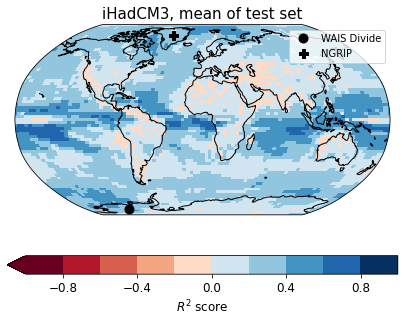

In [13]:
locs = np.array([[-79.5,-112.1],[75.1,-42.3]]) # ,[-75.1, 123.4],[-75.0, 0.1]])
locs[:,1] = locs[:,1]%360
locs_labels = ["WAIS Divide", "NGRIP"] # ,"EPICA - Concordia", "EPICA - Kohnen"]

n_rows=1
n_cols=1

fig, ax = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=np.array([n_cols, n_rows])*r2_style["FIGSIZE"], subplot_kw={'projection': r2_style["PROJECTION"]})
plot_map_markers(ax, locs, np.nanmean(r2_best,axis=(0,1)), descriptions_best[0]["DATASET_DESCRIPTION"], style=r2_style, 
            title=descriptions_best[0]["DATASET_DESCRIPTION"]["CLIMATE_MODEL"]+", mean of test set", locs_labels=locs_labels)

plt.show()

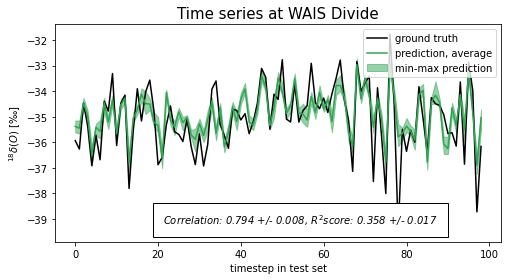

In [14]:
locs = np.array([[-79.5,-112.1],[75.1,-42.3]]) # ,[-75.1, 123.4],[-75.0, 0.1]])
locs[:,1] = locs[:,1]%360
locs_labels = ["WAIS Divide", "NGRIP"] # ,"EPICA - Concordia", "EPICA - Kohnen"]

n_rows=1
n_cols=1

fig, ax = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=np.array([n_cols, n_rows])*timeseries_style["FIGSIZE"])

plot_timeseries(ax, data_pred=np.array(predictions_best), data_gt=gt_best[0], loc=locs[0,:], loc_label=locs_labels[0], description=descriptions_best[0]["DATASET_DESCRIPTION"], style=timeseries_style)

plt.show()

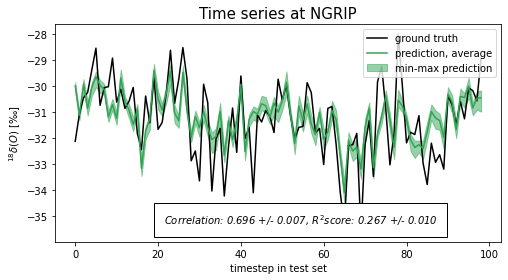

In [15]:
fig, ax = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=np.array([n_cols, n_rows])*timeseries_style["FIGSIZE"])

plot_timeseries(ax, data_pred=np.array(predictions_best), data_gt=gt_best[0], loc=locs[1,:], loc_label=locs_labels[1], description=descriptions_best[0]["DATASET_DESCRIPTION"], style=timeseries_style)

plt.show()

### Test if we can plot these side by side.

In [16]:
locs = np.array([[-79.5,-112.1],[75.1,-42.3]]) # ,[-75.1, 123.4],[-75.0, 0.1]])
locs[:,1] = locs[:,1]%360
locs_labels = ["WAIS Divide", "NGRIP"] # ,"EPICA - Concordia", "EPICA - Kohnen"]

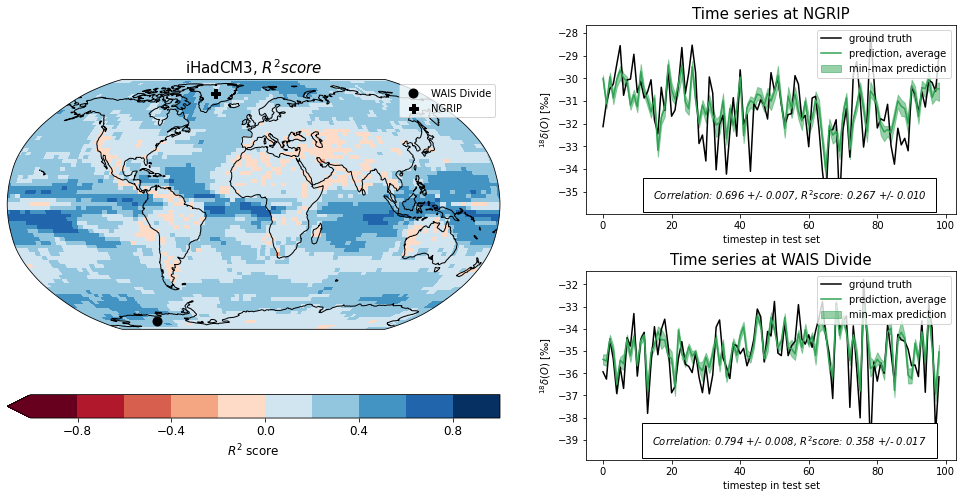

In [17]:
import matplotlib.gridspec as gridspec

locs = np.array([[-79.5,-112.1],[75.1,-42.3]]) # ,[-75.1, 123.4],[-75.0, 0.1]])
locs[:,1] = locs[:,1]%360
locs_labels = ["WAIS Divide", "NGRIP"] # ,"EPICA - Concordia", "EPICA - Kohnen"]



fig = plt.figure(figsize=np.array([timeseries_style["FIGSIZE"][0]+r2_style["FIGSIZE"][0]+2, 
    2*timeseries_style["FIGSIZE"][1]]))
gs = gridspec.GridSpec(2, 2, width_ratios=np.array([4,3]), wspace=0.2, hspace=0.3)

ax = fig.add_subplot(gs[:, 0], projection=r2_style["PROJECTION"])

plot_map_markers(ax, locs, np.nanmean(r2_best,axis=(0,1)), descriptions_best[0]["DATASET_DESCRIPTION"], style=r2_style, 
            title=descriptions_best[0]["DATASET_DESCRIPTION"]["CLIMATE_MODEL"]+r", $R^2score$", locs_labels=locs_labels)

ax_ts1 = fig.add_subplot(gs[1, 1])

plot_timeseries(ax_ts1, data_pred=np.array(predictions_best), data_gt=gt_best[0], loc=locs[0,:], loc_label=locs_labels[0], description=descriptions_best[0]["DATASET_DESCRIPTION"], style=timeseries_style)

ax_ts2 = fig.add_subplot(gs[0, 1])

plot_timeseries(ax_ts2, data_pred=np.array(predictions_best), data_gt=gt_best[0], loc=locs[1,:], loc_label=locs_labels[1], description=descriptions_best[0]["DATASET_DESCRIPTION"], style=timeseries_style)

plt.savefig("Images/iHadCM3_main_plot_default.jpg")
plt.savefig("Images/iHadCM3_main_plot_default.png")
plt.savefig("Images/iHadCM3_main_plot_default.pdf")

plt.show()

### Plot some sample anomalies.

In [18]:
gt_best[0].shape

(99, 1, 71, 96)

In [19]:
import matplotlib.gridspec as gridspec

n_rows = 2
n_cols = 2

np.random.seed(0)
rd_ts = np.random.choice(range(gt_best[0].shape[0]), size = n_rows*n_cols, replace=False)

trainset_mean = get_trainset_mean(descriptions_best[0])
anom_gt = gt_best[0] - trainset_mean
anom_pred = predictions_best[0] - trainset_mean

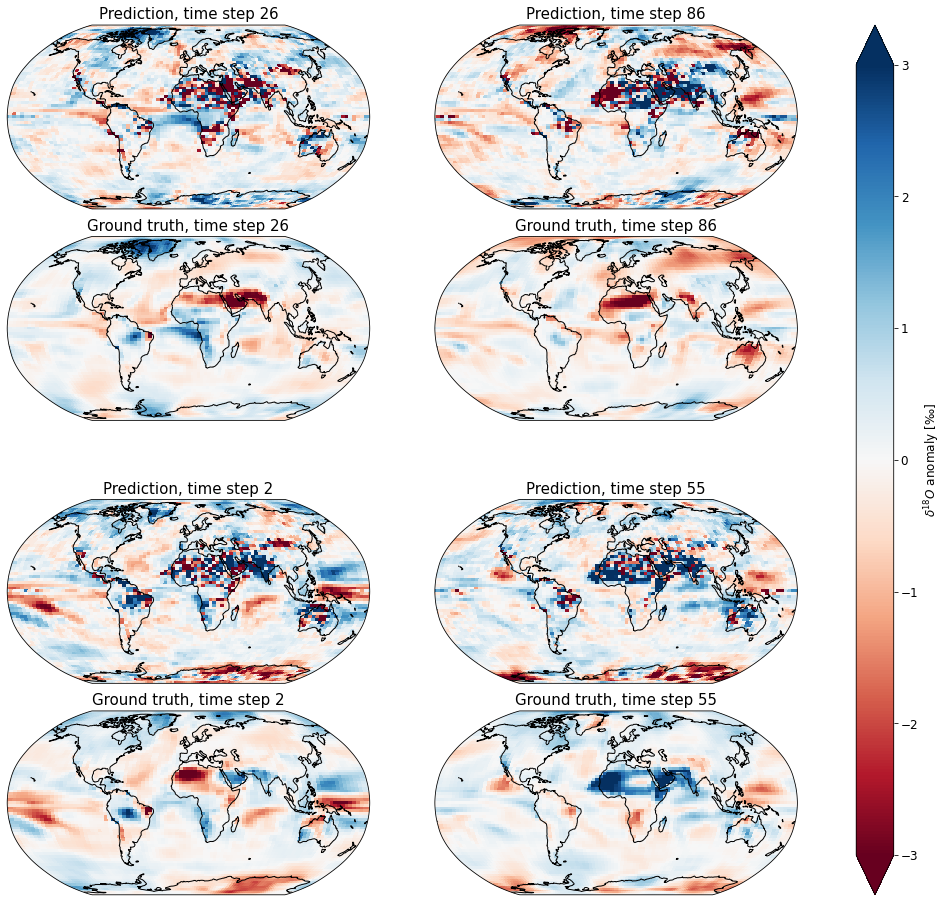

In [20]:
fig = plt.figure(figsize = np.array([n_cols, 2*n_rows])*anom_style["FIGSIZE"])
gs = gridspec.GridSpec(n_rows, n_cols+1, figure=fig, width_ratios=[1,1,0.1])

for i in range(n_rows):
    for j in range(n_cols):
        gs00 = gridspec.GridSpecFromSubplotSpec(2, 1, subplot_spec=gs[i,j], hspace=0.15)
        ax_pred = fig.add_subplot(gs00[0], projection= anom_style["PROJECTION"])
        ax_gt = fig.add_subplot(gs00[1], projection= anom_style["PROJECTION"])
        plot_map(ax_pred, anom_gt[rd_ts[i*n_cols+j],0,...], descriptions_best[0]["DATASET_DESCRIPTION"], anom_style, 
            title="Prediction, time step {}".format(rd_ts[i*n_cols+j]),
            show_colorbar=False)

        plot_map(ax_gt, anom_pred[rd_ts[i*n_cols+j],0,...], descriptions_best[0]["DATASET_DESCRIPTION"], anom_style, 
            title="Ground truth, time step {}".format(rd_ts[i*n_cols+j]),
            show_colorbar=False)

ax_cb=plt.subplot(gs[:,n_cols])

cbar = plt.colorbar(mappable=matplotlib.cm.ScalarMappable(cmap=anom_style["CMAP"], norm=anom_style["NORM"]), cax=ax_cb, extend=anom_style["CBAR_EXTEND"])
cbar.set_label(anom_style["CBAR_LABEL"], fontsize=anom_style["CBAR_FONTSIZE"])
cbar.ax.tick_params(labelsize=anom_style["CBAR_FONTSIZE"])


plt.savefig("Images/iHadCM3_anomalies.jpg")
plt.savefig("Images/iHadCM3_anomalies.png")
plt.savefig("Images/iHadCM3_anomalies.pdf")

plt.show()

### Plot interpolation results.

In [3]:
# load flat model files
conditions_flat = {
    "DATASET_DESCRIPTION": {
                            "PRECIP_WEIGHTING" : False
                           },
    "MODEL_TRAINING_DESCRIPTION": {"MODEL_TYPE": "UNet_Flat",
                                  "USE_COORD_CONV": True,
                                  "USE_CYLINDRICAL_PADDING": True,
                                  "FMAPS": (64,64,128,128),
                                  "LOSS": "Masked_AreaWeightedMSELoss",
                                  }
}

descriptions_flat, predictions_flat, gt_flat, masks_flat = load_data_for_comparison("Output/Reproduce_new/", conditions_flat)
r2_flat_mean = np.zeros(len(predictions_flat))
r2_flat = np.zeros((len(predictions_flat), *predictions_flat[0].shape[1:]))

for i in range(len(predictions_flat)):
    r2_flat[i] = get_r2(predictions_flat[i], gt_flat[i])
    r2_flat_mean[i] = get_weighted_average(get_r2(predictions_flat[i], gt_flat[i]), descriptions_flat[i]["DATASET_DESCRIPTION"])

10 matching runs found


In [14]:
# load interpolated model files
conditions_ico = {
    "DATASET_DESCRIPTION": {
                            "GRID_TYPE": "Flat",
                           },
    "MODEL_TRAINING_DESCRIPTION": {"MODEL_TYPE": "UNet_Ico",
                                  }
}
descriptions_ico, predictions_ico, gt_ico, masks_ico = load_data_for_comparison("Output/Reproduce_new/", conditions_ico)
predictions_ico = np.array(predictions_ico)[...,1:-1,:]

r2_interp_mean = np.zeros(len(predictions_ico))
r2_interp = np.zeros((len(predictions_ico), *predictions_ico[0].shape[1:]))

for i in range(len(predictions_ico)):
    r2_interp[i] = get_r2(predictions_ico[i], gt_ico[i])
    r2_interp_mean[i] = get_weighted_average(get_r2(predictions_ico[i], gt_ico[i]), descriptions_flat[i]["DATASET_DESCRIPTION"])

r2_interp = np.array(r2_interp)

10 matching runs found


In [15]:
# load twice interpolated gt
conditions_tw = {
    "DATASET_DESCRIPTION": {"RESULTS_INTERPOLATED": True,
                            "PRECIP_WEIGHTING" : False,
                            "GRID_TYPE": "Flat"
                           },
    "MODEL_TRAINING_DESCRIPTION": {"MODEL_TYPE": "UNet_Flat",
                                  }
}

descriptions_tw, predictions_tw, gt_tw, masks_tw = load_data_for_comparison("Output/Reproduce_new/", conditions_tw)

predictions_tw = np.array(predictions_tw)[...,1:-1,:]
gt_tw = np.array(gt_tw)[...,1:-1,:]
masks_tw = np.array(masks_tw)[...,1:-1,:]

10 matching runs found


In [16]:
r2_tw_mean = np.zeros(len(predictions_tw))
r2_tw = np.zeros((len(predictions_tw), *predictions_tw[0].shape[1:]))

for i in range(len(predictions_tw)):
    r2_tw[i] = get_r2(predictions_tw[i], gt_flat[i])  # calculate wrt flat
    r2_tw_mean[i] = get_weighted_average(get_r2(predictions_tw[i], gt_flat[i]), descriptions_flat[i]["DATASET_DESCRIPTION"])

r2_tw = np.array(r2_tw)

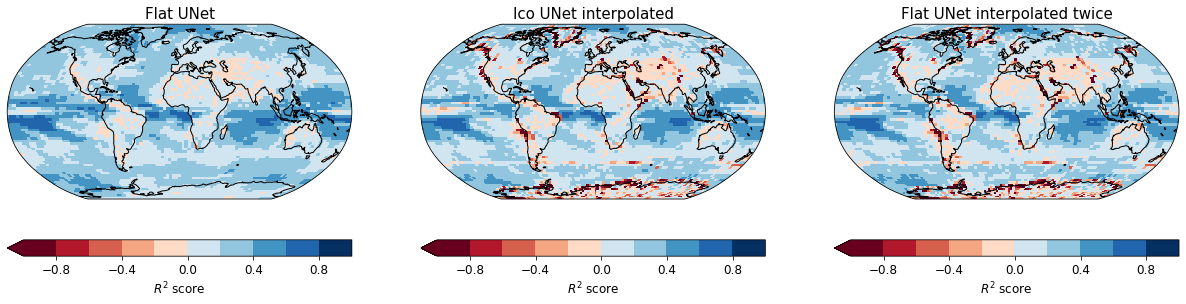

In [23]:
n_rows=1
n_cols=3

fig, ax = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=np.array([n_cols, n_rows])*r2_style["FIGSIZE"], subplot_kw={'projection': r2_style["PROJECTION"]})

# originally on flat grid:
plot_map(ax[0], np.mean(r2_flat,axis=(0,1)), descriptions_flat[0]["DATASET_DESCRIPTION"], r2_style, 
            title="Flat UNet")

# ico unet interpolated to flat grid:
plot_map(ax[1], np.mean(r2_interp,axis=(0,1)), descriptions_flat[0]["DATASET_DESCRIPTION"], r2_style, 
            title="Ico UNet interpolated")

# ico interpolated to flat grid:
plot_map(ax[2], np.mean(r2_tw,axis=(0,1)), descriptions_flat[0]["DATASET_DESCRIPTION"], r2_style, 
            title="Flat UNet interpolated twice")

plt.savefig("Images/results_unets_on_flat_grid.jpg")
plt.savefig("Images/results_unets_on_flat_grid.png")
plt.savefig("Images/results_unets_on_flat_grid.pdf")
plt.show()